In [1]:
# Run 'source ~/.profile'
import satpy
from satpy import Scene
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from global_land_mask import globe

sys.path.insert(0,'/home/cameron/Projects/')

In [2]:
points_file = '/home/cameron/Dokumenter/Data/frohavet/frohavet_2023-03-29_1044Z-bin3.points'
nc_file = '/home/cameron/Dokumenter/Data/frohavet/frohavet_2023-03-29_1044Z-l1a.nc'

In [3]:

l1a_prefix = nc_file.rsplit('-', maxsplit=1)[0]
l1a_file_prefix = l1a_prefix.split('/')[-1]

files = [points_file, nc_file] # List of files to be read by SatPy

# Create SatPy scene
scene = Scene(filenames=files, reader='hypso1_l1a_nc', reader_kwargs={'flip': True})


Processing *nominal* Image with Dimensions: (956, 684)
Radiometric Correction Ongoing
Smile Correction Ongoing
Destriping Correction Ongoing
L1b.nc file already exists. Not creating it.
Found L2_6SV1.npy
Getting Projection Data without lat/lon correction =========================================
Generating Geotiff ************************************
  Projecting pixel geodetic to map ...
    [62.550682, 65.285, 7.741144, 11.630998]
    using UTM map: WGS 84 / UTM zone 32N EPSG: 32632
    Area covered by image: 19746930141.682255 m^2 = 19746.930141682256 km^2
  Bounding boxes and resample grid ...
  Grid points inside bounding polygon ...
    Points inside boundary: 1286866 / 3743724
  Registration, aka rectification, aka resampling, aka gridding ...
      Starting band 11
      Starting band 61
      Starting band 50
      Starting band 31
      Done with band 61
      Done with band 50
      Done with band 31
      Done with band 11
Done RGB/RGBA Geotiff
RGBA Tif File:  frohavet_2023

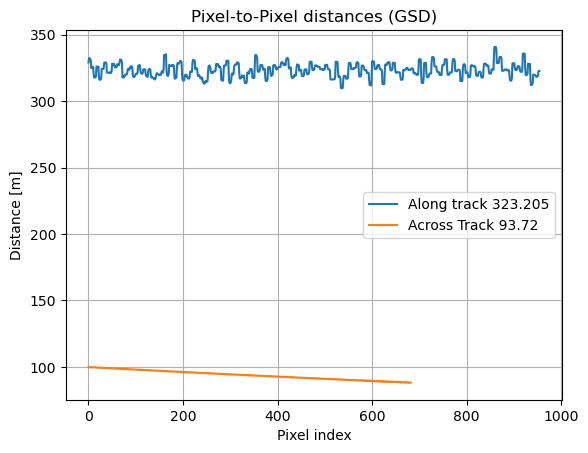

In [3]:
import hypso
from hypso.experimental.chlorophyll import start_chl_estimation

hypso_file_path=nc_file
satobj = hypso.Hypso(hypso_file_path)


In [11]:
satobj.l2a_cube['6SV1'].shape

(956, 684, 120)

In [6]:
# user and password from https://urs.earthdata.nasa.gov/profile
# optional but good
atmos_params = {
    'user':'alvarof',
    'password':'nwz7xmu8dak.UDG9kqz',
    'aot550': 0.0580000256
}

satobj.create_geotiff(product="L2-6SV1", force_reload=False, atmos_dict=atmos_params)


-------  Py6S Atmospheric Correction  ----------
ROI:
Max Lat: 65.28500366210938  Min Lat: 62.550682067871094
Max Lon: 11.630997657775879  Min Lon: 7.741144180297852


100%|██████████| 120/120 [00:30<00:00,  3.99it/s]


Generating Geotiff ************************************
  Projecting pixel geodetic to map ...
    [62.550682, 65.285, 7.741144, 11.630998]
    using UTM map: WGS 84 / UTM zone 32N EPSG: 32632
    Area covered by image: 19746930141.682255 m^2 = 19746.930141682256 km^2
  Bounding boxes and resample grid ...
  Grid points inside bounding polygon ...
    Points inside boundary: 1286866 / 3743724
  Registration, aka rectification, aka resampling, aka gridding ...
      Starting band 0
      Starting band 1
      Starting band 2
      Starting band 3
      Starting band 4
      Starting band 5
      Starting band 6
      Starting band 7
      Starting band 8
      Starting band 9
      Starting band 10
      Starting band 11
      Starting band 12
      Starting band 13
      Starting band 14
      Starting band 15
      Starting band 16
      Starting band 17
      Starting band 18
      Starting band 19
      Starting band 20
      Starting band 21
      Starting band 22
      Starting ba

In [4]:
start_chl_estimation(sat_obj=satobj, model_path='/home/cameron/Dokumenter/Chlorophyll_NN_Models/model_acolite_aqua_tuned.joblib')

KeyError: 'ACOLITE'

In [3]:
scene['band_0']

KeyError: "No dataset matching 'DataQuery(name='band_0')' found"

In [4]:
datasets = scene.available_dataset_names()
scene.load(datasets)
ds = scene.to_xarray()



import re

band_names = scene.all_dataset_names()

# Remove latitude and longitude
band_names.remove('latitude')
band_names.remove('longitude')

# Extract numbers and sort
sorted_band_names = sorted(band_names, key=lambda x: int(re.search(r'\d+', x).group()))


ds = ds[sorted_band_names]

#da = ds.to_stacked_array('band', sample_dims=['y','x'])
#da.drop_vars(['latitude', 'longitude'])
#da.to_numpy().shape
da = ds.to_stacked_array('band', sample_dims=['y','x'])


In [5]:
datacube = da.to_numpy()

In [7]:
datacube.shape

(956, 684, 120)

NameError: name 'pd' is not defined

In [ ]:
# Compute wl and choose bands for band ratio
spectral_coeffs = [ -5.719788129534360902e-09,
                    1.324037080791479811e-05, 
                    3.751455956374321055e-01,
                    2.264762366937773663e+02]
x_start = 428
x_stop = 1508
image_width = 120

x = np.linspace(x_start, x_stop, image_width)

h1_wl = spectral_coeffs[3] + spectral_coeffs[2]*x + spectral_coeffs[1]*x*x + spectral_coeffs[0]*x*x*x


a = abs(h1_wl-549)
min_index = np.argmin(a)
band_549nm_name = 'band_' + str(min_index)

a = abs(h1_wl-663)
min_index = np.argmin(a)
band_663nm_name = 'band_' + str(min_index)

scene.load(['latitude', 'longitude', band_549nm_name, band_663nm_name])
#datasets = scene.available_dataset_names()
#scene.load(datasets)

print(band_549nm_name)
print(scene['band_46'].wavelength) # This does not match?

print(band_663nm_name)
print(scene['band_78'].wavelength) # This does not match?

band_46
550
band_78
662


In [19]:
rrs_list = [
    "Rrs_389", "Rrs_393", "Rrs_397", "Rrs_400", "Rrs_404", "Rrs_407", "Rrs_411", "Rrs_414", "Rrs_418", "Rrs_421",
    "Rrs_425", "Rrs_428", "Rrs_432", "Rrs_436", "Rrs_439", "Rrs_443", "Rrs_446", "Rrs_450", "Rrs_453", "Rrs_457",
    "Rrs_460", "Rrs_464", "Rrs_467", "Rrs_471", "Rrs_474", "Rrs_478", "Rrs_481", "Rrs_485", "Rrs_489", "Rrs_492",
    "Rrs_496", "Rrs_499", "Rrs_503", "Rrs_506", "Rrs_510", "Rrs_513", "Rrs_517", "Rrs_520", "Rrs_524", "Rrs_527",
    "Rrs_531", "Rrs_534", "Rrs_538", "Rrs_541", "Rrs_545", "Rrs_548", "Rrs_552", "Rrs_555", "Rrs_559", "Rrs_562",
    "Rrs_566", "Rrs_569", "Rrs_573", "Rrs_576", "Rrs_580", "Rrs_583", "Rrs_587", "Rrs_590", "Rrs_594", "Rrs_597",
    "Rrs_601", "Rrs_604", "Rrs_608", "Rrs_611", "Rrs_615", "Rrs_618", "Rrs_621", "Rrs_625", "Rrs_628", "Rrs_632",
    "Rrs_635", "Rrs_639", "Rrs_642", "Rrs_646", "Rrs_649", "Rrs_653", "Rrs_656", "Rrs_660", "Rrs_663", "Rrs_667",
    "Rrs_670", "Rrs_674", "Rrs_677", "Rrs_680", "Rrs_684", "Rrs_687", "Rrs_691", "Rrs_694", "Rrs_698", "Rrs_701",
    "Rrs_705", "Rrs_708", "Rrs_711", "Rrs_715", "Rrs_718", "Rrs_722", "Rrs_725", "Rrs_729", "Rrs_732", "Rrs_736",
    "Rrs_739", "Rrs_742", "Rrs_746", "Rrs_749", "Rrs_753", "Rrs_756", "Rrs_760", "Rrs_763", "Rrs_766", "Rrs_770",
    "Rrs_773", "Rrs_777", "Rrs_780", "Rrs_784", "Rrs_787", "Rrs_790", "Rrs_794", "Rrs_797", "Rrs_801", "Rrs_804"
]


In [24]:
from hypso.experimental.chlorophyll import start_chl_estimation
from hypso.experimental.chlorophyll.utilities_chl import convolve2d
from hypso.experimental.chlorophyll.estimate_chlorophyll_ml import get_best_features
import pandas as pd
from joblib import dump, load

model_path = '/home/cameron/Dokumenter/Chlorophyll_NN_Models/model_6sv1_aqua_tuned.joblib'

model = load(model_path)

rrs_cube = datacube

channels = rrs_cube.shape[2]
rrs_array = rrs_cube.reshape((-1, channels))

hypso_string_wl = rrs_list

rrs_df = pd.DataFrame(rrs_array, columns=hypso_string_wl)

hypso_optimal_features_df, _ = get_best_features(rrs_df, None, rrs_df, None, dataset_name="hypso")
hypso_optimal_features_df = hypso_optimal_features_df.loc[:, hypso_optimal_features_df.columns != 'Chla']

# Filter -----------------------------------------------------------------
sub_params = ["bratio"]
sub_params = ["bratio", "bratio_log", "tbvi", "diff"]
pre_filter = [k for k in hypso_optimal_features_df.columns for w in k.split("-") if w in sub_params]

hypso_optimal_features_df = hypso_optimal_features_df[
    hypso_optimal_features_df.columns.intersection(pre_filter)]

estimation = model.predict(hypso_optimal_features_df)

print(estimation)



[2.15529146 2.13101682 1.5336624  ... 1.78732523 1.9496627  1.96581794]


In [28]:

estimation = np.reshape(estimation, (datacube.shape[0], datacube.shape[1]))

# smooth ------------------------------------------------------------
kernel = np.array([[1 / 16, 1 / 8, 1 / 16],  # 3x3 kernel
                    [1 / 8, 1 / 4, 1 / 8],
                    [1 / 16, 1 / 8, 1 / 16]], dtype=float)
estimation = convolve2d(estimation, kernel, max_missing=0.5, verbose=True)

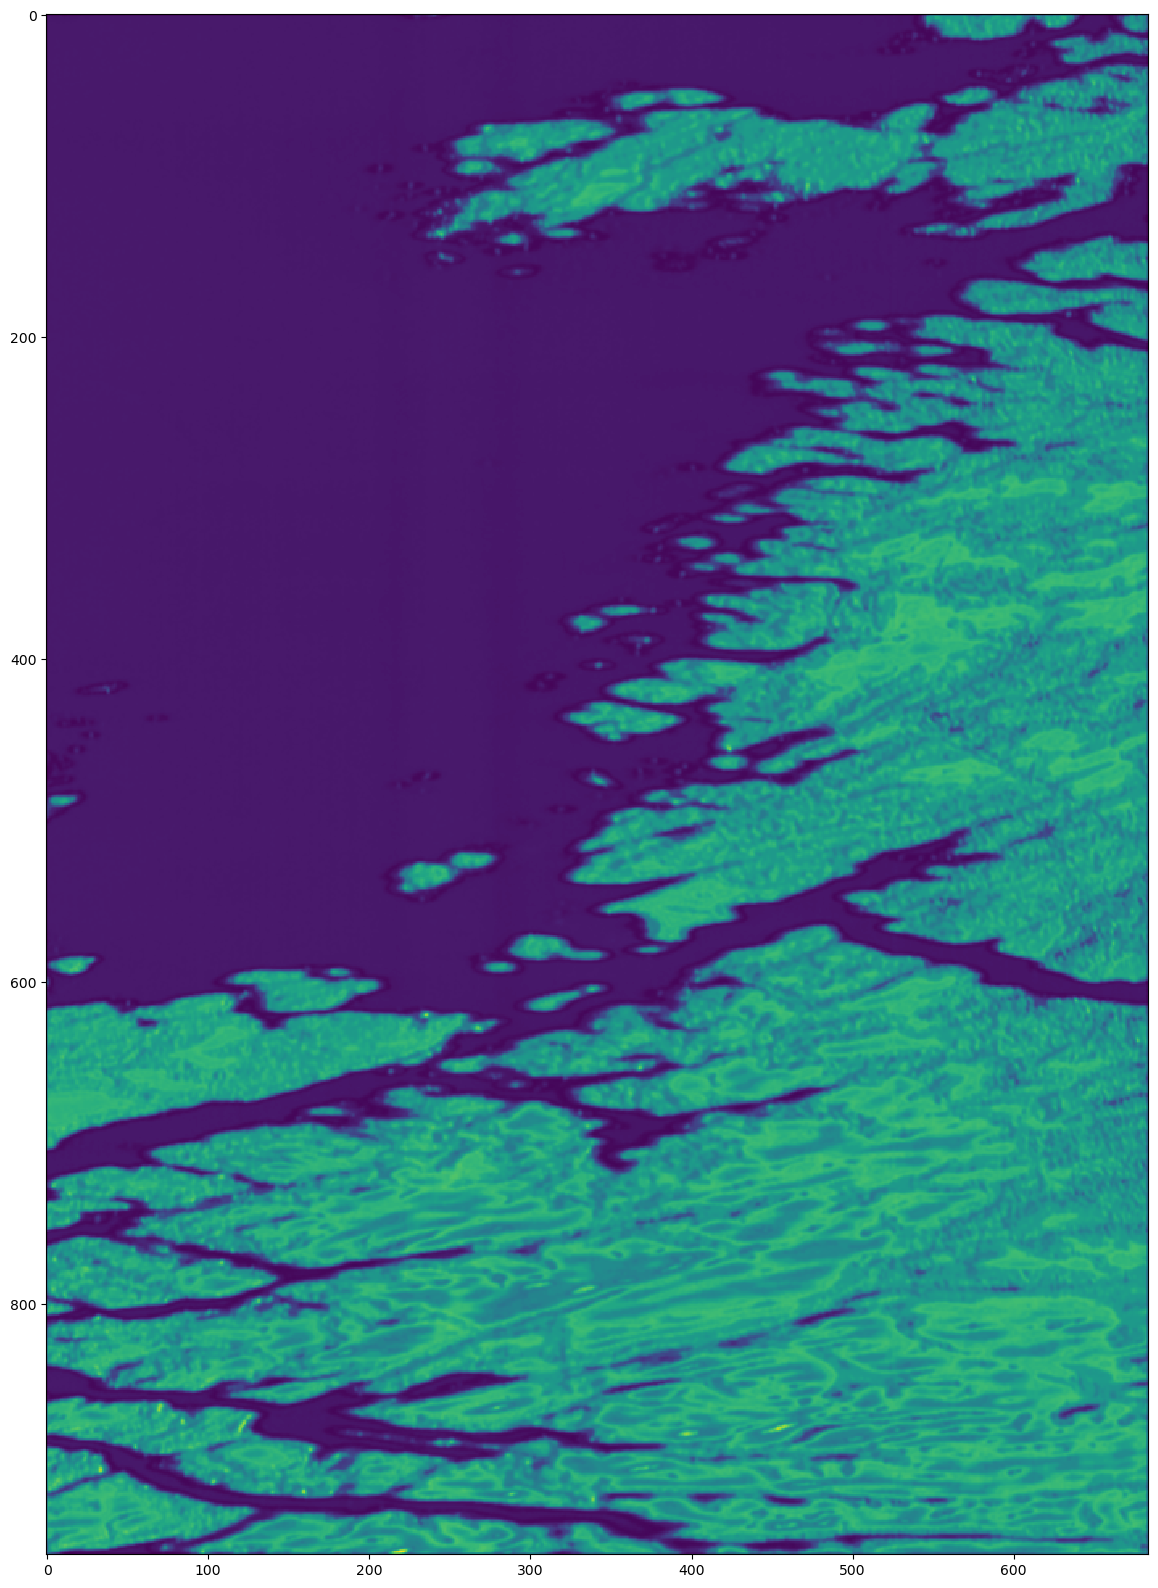

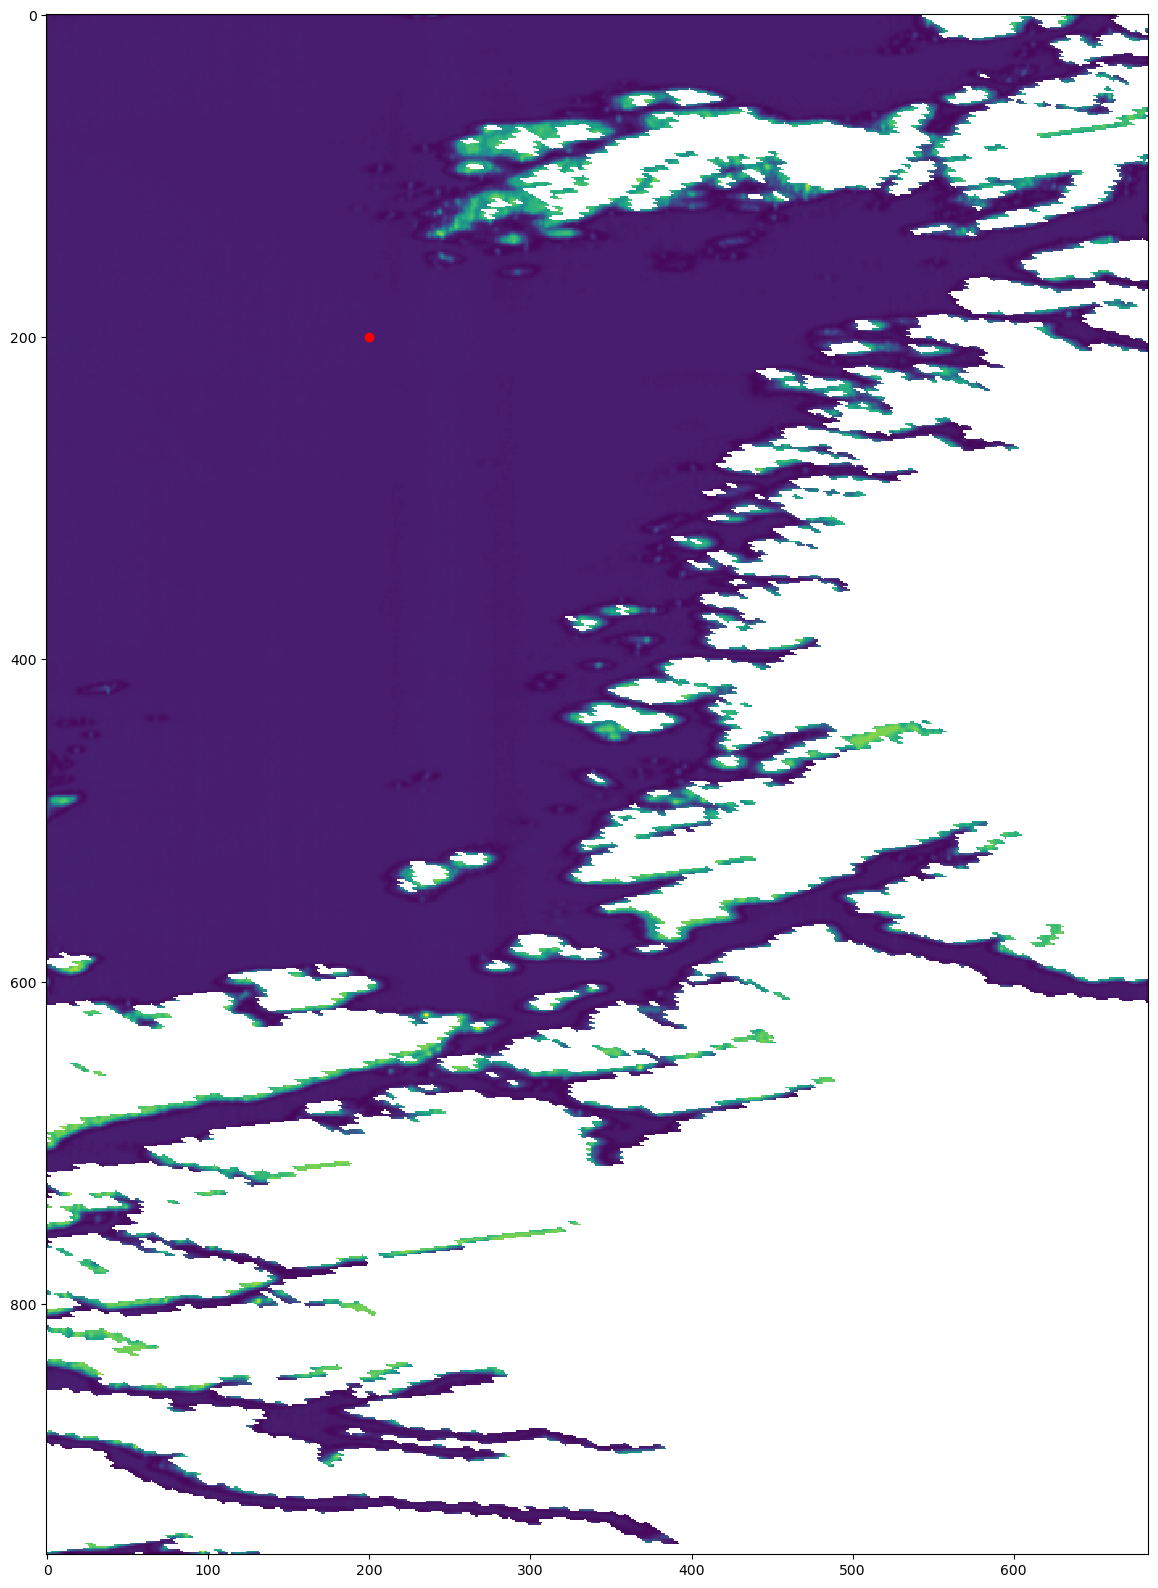

In [31]:
plt.figure(figsize=(20,20))
plt.imshow(estimation[:,::-1], interpolation='none')

# Chlorophyll estimates
chlor = estimation

chlor = np.ma.masked_array(chlor, land_mask, fill_value=np.nan)


chlor = chlor[:,::-1]

plt.figure(figsize=(20,20))
plt.imshow(chlor, interpolation='none')
plt.plot(200,200,'ro') 

# Concentration in units mg m-3


In [ ]:
# Get image dimensions
img_dims = scene['latitude'].shape

# Land mask
land_mask = np.zeros(img_dims, dtype=bool)

lats = scene['latitude'].data
lons = scene['longitude'].data

for x in range(0,img_dims[0]):
    for y in range(0,img_dims[1]):
        lat = lats[x][y]
        lon = lons[x][y]
        land_mask[x][y] = globe.is_land(lat, lon)

# Cloud mask
cloud_mask = np.zeros(img_dims, dtype=bool)

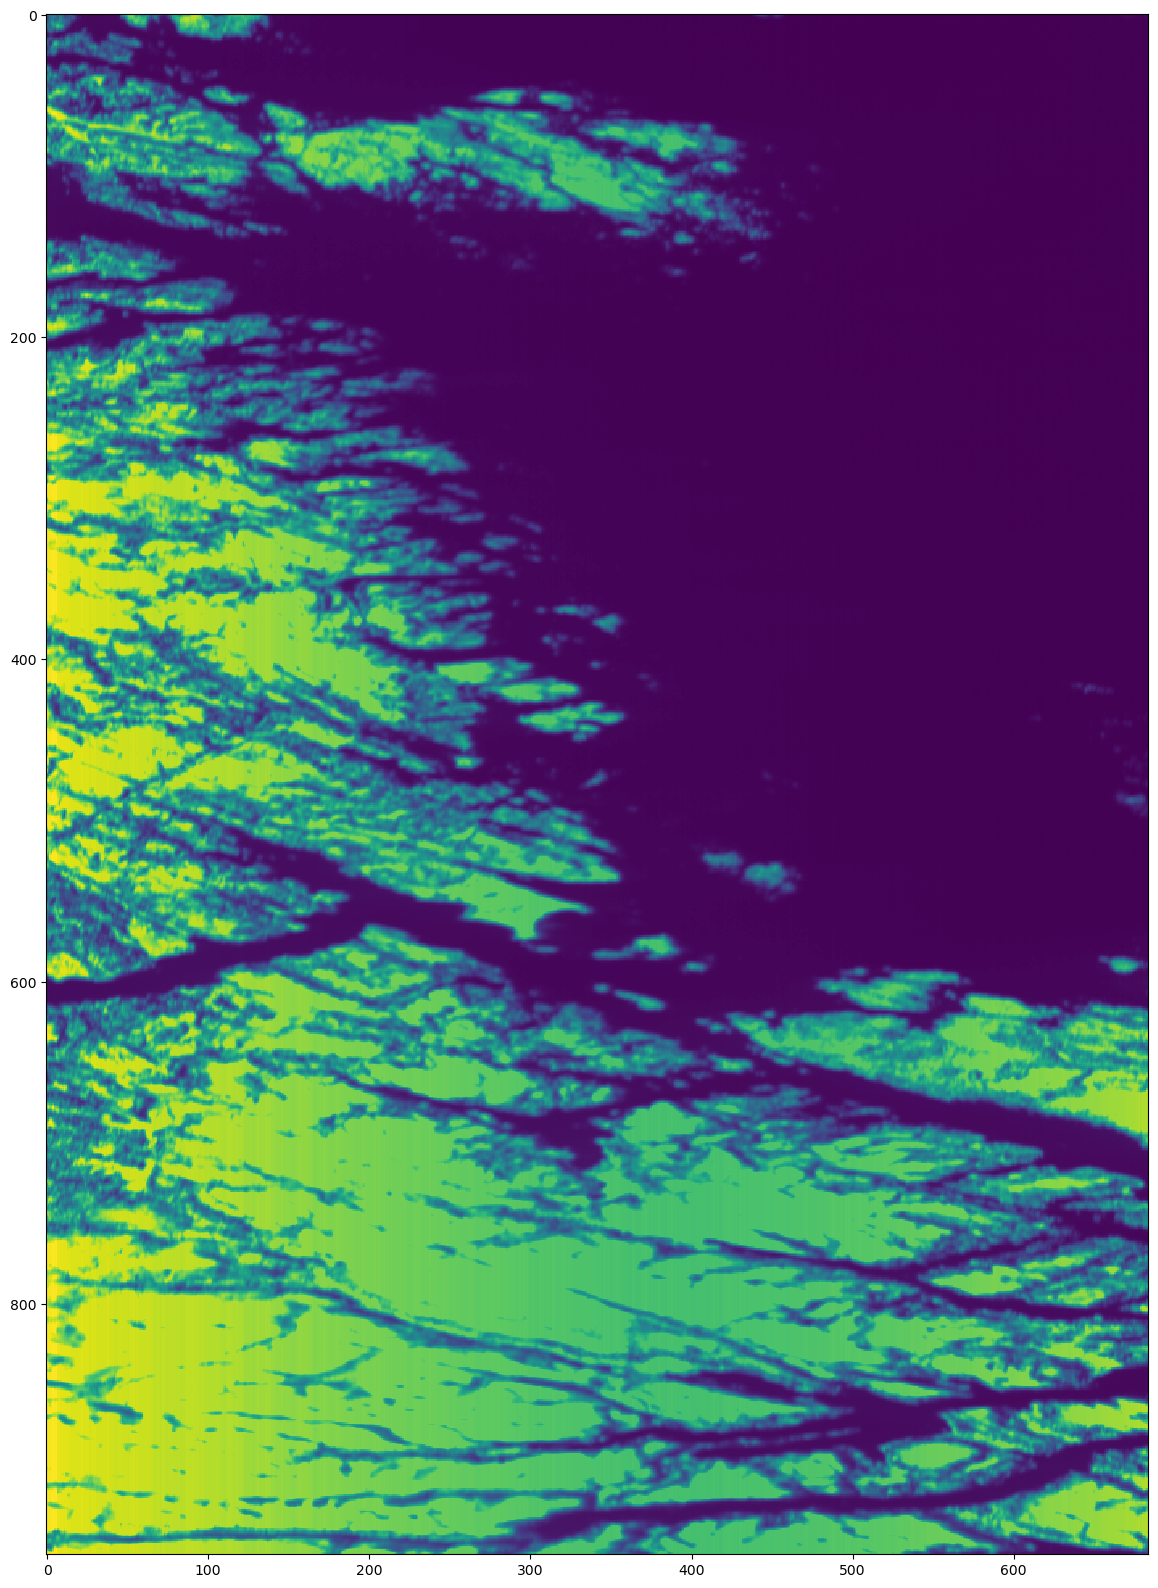

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(scene[band_549nm_name], interpolation='none')
#scene.show(band_549nm_name)

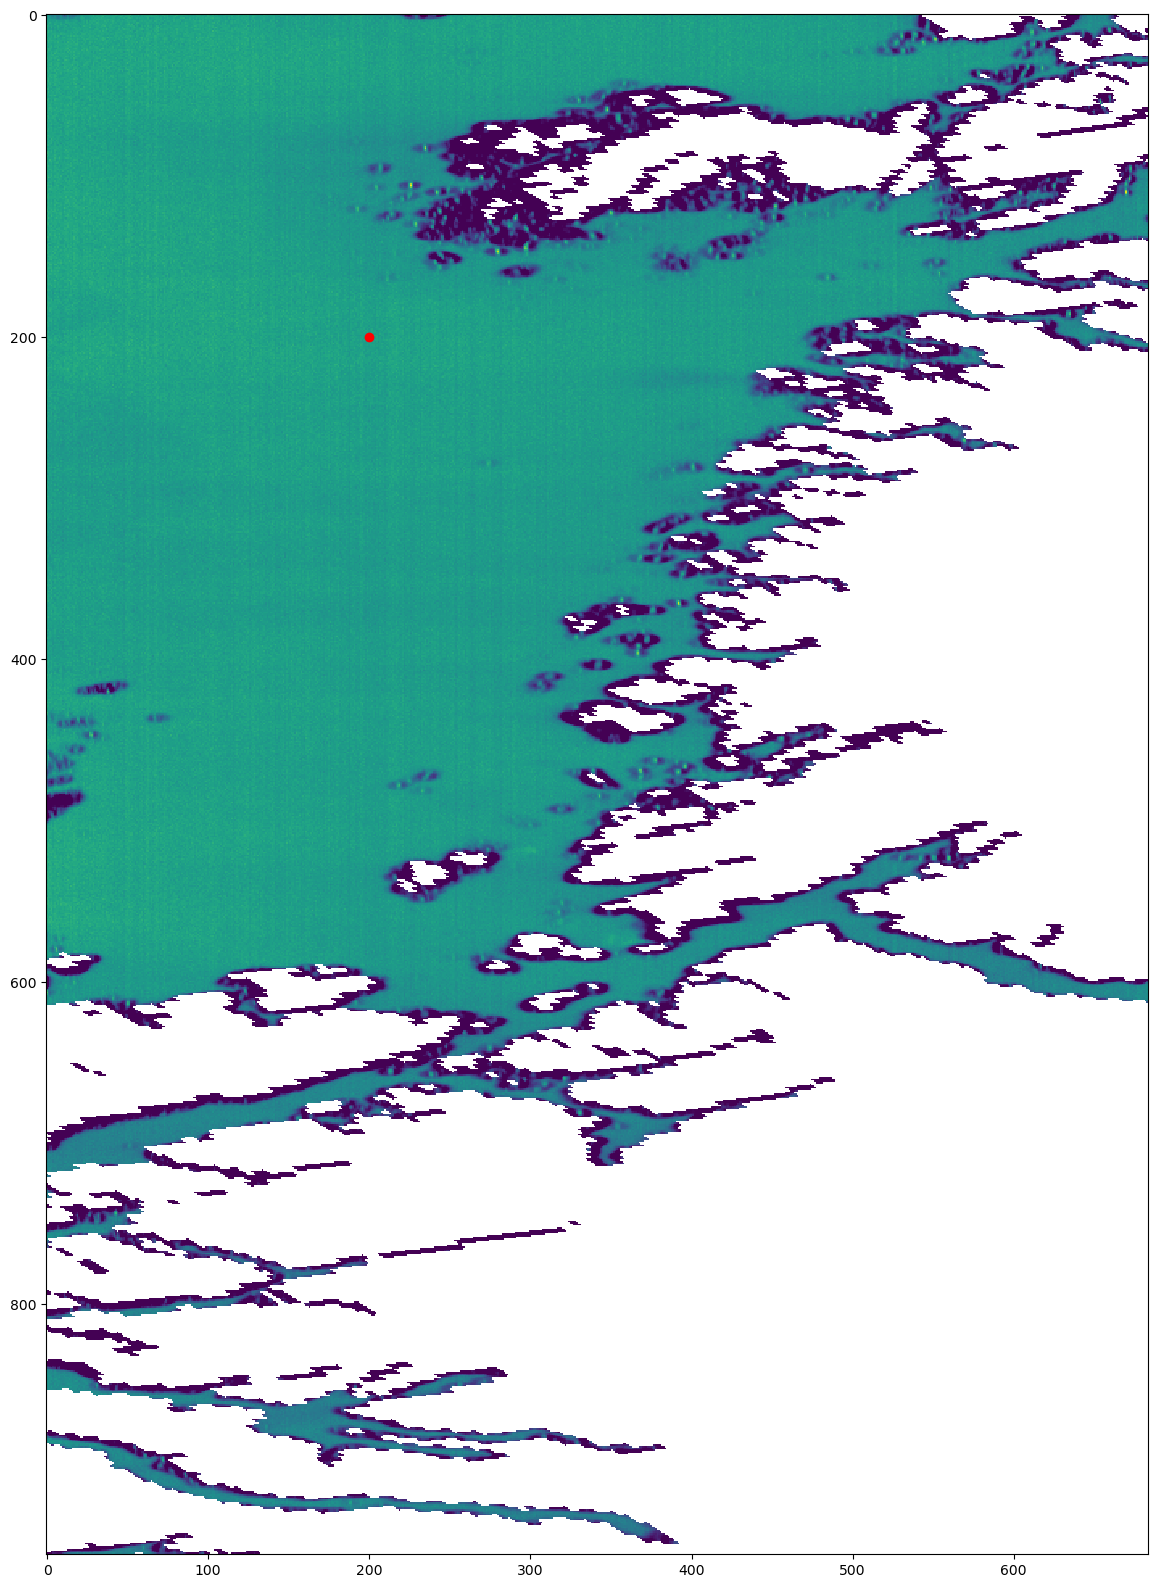

In [ ]:
# Chlorophyll estimates
chlor = scene[band_549nm_name] / scene[band_663nm_name]
chlor = chlor.to_numpy()

chlor = np.ma.masked_array(chlor, land_mask, fill_value=np.nan)

chlor = chlor - 0.5*chlor.compressed().max()
#chlor = chlor - 0.88*chlor.compressed().max()
chlor[chlor < 0] = 0

chlor = chlor[:,::-1]

plt.figure(figsize=(20,20))
plt.imshow(chlor, interpolation='none')
plt.plot(200,200,'ro') 

# Concentration in units mg m-3

In [ ]:
chlor[200,200]

1.8822274

In [ ]:
coords = scene[band_549nm_name].coords

scene['chlor_a'] = xr.DataArray(chlor, coords=coords)
scene['chlor_a'].attrs['area'] = scene[band_549nm_name].attrs['area']
scene['chlor_a'].attrs['start_time'] = scene[band_549nm_name].attrs['start_time']
scene['chlor_a'].attrs['end_time'] = scene[band_549nm_name].attrs['end_time']
scene['chlor_a'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['chlor_a'].attrs['ancillary_variables'] = []

scene['land_mask'] = xr.DataArray(land_mask, coords=coords)
scene['land_mask'].attrs['area'] = scene[band_549nm_name].attrs['area']
scene['land_mask'].attrs['start_time'] = scene[band_549nm_name].attrs['start_time']
scene['land_mask'].attrs['end_time'] = scene[band_549nm_name].attrs['end_time']
scene['land_mask'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['land_mask'].attrs['ancillary_variables'] = []

scene['cloud_mask'] = xr.DataArray(cloud_mask, coords=coords)
scene['cloud_mask'].attrs['area'] = scene[band_549nm_name].attrs['area']
scene['cloud_mask'].attrs['start_time'] = scene[band_549nm_name].attrs['start_time']
scene['cloud_mask'].attrs['end_time'] = scene[band_549nm_name].attrs['end_time']
scene['cloud_mask'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['cloud_mask'].attrs['ancillary_variables'] = []

scene.save_datasets(writer='cf', 
                    datasets=['chlor_a', 'land_mask', 'cloud_mask'], 
                    filename = './datasets_out/' + l1a_file_prefix+'-chlor_a' + '.nc')

/home/cameron/miniforge3/lib/python3.10/site-packages/satpy/writers/cf_writer.py:274: UserWarning: dtype bool not compatible with CF-1.7.
  grouped_datasets, header_attrs = collect_cf_datasets(list_dataarrays=datasets,  # list of xr.DataArray


[None]

In [ ]:
datasets = scene.available_dataset_names()
scene.load(datasets)
ds = scene.to_xarray()
da = ds.to_stacked_array('band', sample_dims=['lines','samples'])
da.to_numpy().shape

/home/cameron/miniforge3/lib/python3.10/site-packages/satpy/_scene_converters.py:95: UserWarning: dtype bool not compatible with CF-1.7.
  grouped_datasets, header_attrs = collect_cf_datasets(list_dataarrays=list_dataarrays,


ValueError: Variables in the dataset must contain all ``sample_dims`` (['lines', 'samples']) but 'band_0' misses ['lines', 'samples']